# 🔬 Eksperimen ASR 1: Size-Performance Trade-off Benchmark
**Researcher:** Muhammad Hendika Putra  
**Date:** 2026  
**Dataset:** Google FLEURS (id_id) - Test Split  
**Models:** OpenAI Whisper (Tiny vs Small)

---
### 🎯 Tujuan Eksperimen
Mengevaluasi kinerja model ASR dengan ukuran berbeda pada dataset Bahasa Indonesia (Real-world Audio).

### 📊 Metrik Evaluasi
1.  **WER (Word Error Rate):** Mengukur persentase kesalahan kata. (Lower is Better).
2.  **RTF (Real-Time Factor):** Mengukur kecepatan inferensi relatif terhadap durasi audio. (Lower is Better).
    * *RTF < 1.0:* Lebih cepat dari real-time.
    * *RTF > 1.0:* Lambat/Laggy.

Kita menginstal library spesifik untuk riset audio.
*  datasets: Pustaka resmi Hugging Face untuk mengakses dataset akademik (FLEURS).
*  jiwer: Standar emas industri untuk menghitung WER (Word Error Rate).
*  librosa: Untuk memproses array audio dan durasi.
*  accelerate: Wajib ada untuk optimalisasi GPU di Colab T4.









In [17]:
# @title 1. Environment Setup
# Menggunakan -q (quiet) agar log instalasi tidak memenuhi layar
%pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu124
%pip install "datasets==2.19.0" transformers librosa accelerate jiwer soundfile pandas seaborn matplotlib  --quiet

print("✅ Environment Ready.")
print("✅ Libraries Installed: Transformers, Datasets, Jiwer, Librosa")

Looking in indexes: https://download.pytorch.org/whl/cu124
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.
✅ Environment Ready.
✅ Libraries Installed: Transformers, Datasets, Jiwer, Librosa



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Ini adalah tahap paling krusial dalam riset ASR profesional. Komputer itu bodoh; baginya, "Halo." (dengan titik) dan "halo" (tanpa titik) adalah kata yang berbeda. Jika tidak dinormalisasi, nilai Error (WER) akan tinggi palsu. Fungsi ini membersihkan teks agar perbandingan adil ("apple to apple").

In [18]:
import re
import string

class TextNormalizer:
    """
    Standar Pre-processing untuk Evaluasi ASR.
    Bertujuan menyamakan format antara Ground Truth (Dataset) dan Prediksi (Model).
    """

    @staticmethod
    def normalize(text):
        if not isinstance(text, str):
            return ""

        # 1. Lowercase (Huruf kecil semua)
        text = text.lower()

        # 2. Hapus Tanda Baca (Punctuation Removal)
        # Mengubah "Halo, apa kabar?" menjadi "halo apa kabar"
        text = text.translate(str.maketrans('', '', string.punctuation))

        # 3. Hapus Whitespace Ganda
        # Mengubah "halo   apa" menjadi "halo apa"
        text = re.sub(r'\s+', ' ', text).strip()

        return text

# Unit Test Sederhana untuk memastikan fungsi berjalan
sample_text = "Halo, Pak! Apakah data ke-5 sudah siap?"
print(f"Original  : {sample_text}")
print(f"Normalized: {TextNormalizer.normalize(sample_text)}")

Original  : Halo, Pak! Apakah data ke-5 sudah siap?
Normalized: halo pak apakah data ke5 sudah siap


Kita membagi kode menjadi dua Kelas (Class) utama agar modular:
1.   ASRInferenceEngine: Bertanggung jawab teknis memuat model ke GPU dan melakukan transkripsi.
2.   BenchmarkManager: Bertanggung jawab manajerial—mengambil data, menyuruh Engine bekerja, menghitung skor, dan mencatat hasil ke tabel.

In [19]:
import os
import torch
from transformers import pipeline
import time
from jiwer import wer
import pandas as pd
from tqdm import tqdm # Progress bar
import soundfile as sf

class ASRInferenceEngine:
    """
    Kelas Worker: Menangani Model AI dan Transkripsi.
    """
    def __init__(self, model_id):
        print("=== Pengecekan Device PyTorch ===")
        print(f"CUDA Available (GPU Nvidia): {torch.cuda.is_available()}")

        if torch.cuda.is_available():
            device_count = torch.cuda.device_count()
            print(f"Jumlah GPU terdeteksi: {device_count}")
            
            for i in range(device_count):
                print(f" -> GPU {i}: {torch.cuda.get_device_name(i)}")
                print(f"    Memory Capability: {torch.cuda.get_device_capability(i)}")
        else:
            print("❌ GPU tidak terdeteksi. PyTorch berjalan di CPU.")
        
        self.device = "cuda:0" if torch.cuda.is_available() else "cpu"
        self.model_id = model_id
        print(f"⚙️ Loading Model: {model_id} on {self.device}...")

        # Inisialisasi Pipeline
        self.pipe = pipeline(
            "automatic-speech-recognition",
            model=model_id,
            chunk_length_s=30,
            device=self.device
        )

    def predict(self, audio_array):
        """Melakukan inferensi pada satu sampel audio"""
        start_time = time.time()

        # generate_kwargs={"language": "indonesian"} penting untuk Whisper
        # agar model fokus ke bahasa target
        prediction = self.pipe(
            audio_array,
            batch_size=1,
            generate_kwargs={"language": "indonesian"}
        )

        end_time = time.time()
        inference_time = end_time - start_time

        return prediction['text'], inference_time

class BenchmarkManager:
    """
    Kelas Manager: Mengelola Dataset, Evaluasi, dan Metrik.
    """
    def __init__(self, dataset_stream):
        self.dataset_stream = dataset_stream
        self.results = []

    def run_evaluation(self, model_name, num_samples=50):
        engine = ASRInferenceEngine(model_name)

        print(f"🚀 Memulai Evaluasi {model_name} pada {num_samples} sampel...")

        # Iterasi dataset
        # Menggunakan 'take(num_samples)' untuk mengambil sebagian data dari stream
        counter = 0

        audio_folder = "exp1_size_vs_performance_results3_audio_samples"
        os.makedirs(audio_folder, exist_ok=True)

        for i, sample in tqdm(enumerate(self.dataset_stream), total=num_samples):
            if counter >= num_samples: break

            # 1. Extract Data
            audio_data = sample['audio']
            audio_array = audio_data['array']
            sampling_rate = audio_data['sampling_rate']
            ground_truth = sample['raw_transcription']

            # Tentukan nama file audio
          
            file_name = f"sample_{counter:03d}.wav"

            save_path = os.path.join(audio_folder, file_name)

            sf.write(save_path, audio_array, sampling_rate)

            # Hitung durasi (jumlah sample / sampling rate)
            duration = len(audio_array) / sampling_rate

            # 2. Transkripsi
            pred_text, exec_time = engine.predict(audio_array)

            # 3. Normalisasi (PENTING)
            try:
                ref_norm = TextNormalizer.normalize(ground_truth)
                pred_norm = TextNormalizer.normalize(pred_text)
            except NameError:
                # Fallback jika TextNormalizer lupa didefinisikan
                ref_norm = ground_truth.lower()
                pred_norm = pred_text.lower()

            if not ref_norm: continue # Skip jika data kosong

            # 4. Hitung Metrik
            # WER: Word Error Rate
            try:
                sample_wer = wer(ref_norm, pred_norm)
            except:
                sample_wer = 1.0 # Fallback jika error

            # RTF: Real Time Factor
            sample_rtf = exec_time / duration

            # 5. Simpan Log
            self.results.append({
                "Model": model_name,
                "Duration_s": round(duration, 2),
                "Inference_Time_s": round(exec_time, 4),
                "RTF": round(sample_rtf, 4),
                "WER": round(sample_wer, 4),
                "Ref": ref_norm,
                "Pred": pred_norm
            })

            counter += 1

        # Bersihkan memori GPU setelah selesai satu model
        del engine
        torch.cuda.empty_cache()

    def get_dataframe(self):
        return pd.DataFrame(self.results)

Kita menggunakan mode streaming=True.

Kenapa? Dataset audio itu besar (bisa 50GB+). Colab gratis akan crash jika didownload semua.

Solusi: Streaming memungkinkan kita mendownload audio satu per satu saat dibutuhkan saja (on-the-fly). Kita pakai Google FLEURS (subset Indonesia id_id) split test.

In [20]:
from datasets import load_dataset

# @title Load Dataset Configuration
print("📡 Menghubungkan ke Google FLEURS Dataset (Indonesia)...")

# Kita gunakan split 'test'
dataset = load_dataset(
    "google/fleurs",
    "id_id",
    split="test",
    streaming=True,
    trust_remote_code=True  # Ini akan bekerja kembali setelah downgrade
)

print("✅ Dataset Stream Ready. Siap dialirkan.")

📡 Menghubungkan ke Google FLEURS Dataset (Indonesia)...
✅ Dataset Stream Ready. Siap dialirkan.


Ini adalah tombol "Start". Kita mendefinisikan model apa saja yang mau diadu.

Dalam contoh ini, kita memakai whisper-tiny dan whisper-small.

Jumlah sampel diset NUM_SAMPLES = 30 agar proses selesai dalam 2-3 menit. Untuk riset akhir yang serius, naikkan menjadi 100 atau 200.

In [21]:
# @title Jalankan Eksperimen

# 1. Konfigurasi
MODELS_TO_TEST = [
    "openai/whisper-tiny",  # Model Kecil (Cepat)
    "openai/whisper-small"  # Model Sedang (Akurat)
]
NUM_SAMPLES = 30 # Ubah jadi 100+ untuk hasil lebih valid

# 2. Inisialisasi Manager
benchmark = BenchmarkManager(dataset)

# 3. Loop Pengujian
for model_id in MODELS_TO_TEST:
    try:
        benchmark.run_evaluation(model_id, num_samples=NUM_SAMPLES)
    except Exception as e:
        print(f"❌ Error pada {model_id}: {e}")

# 4. Ambil Hasil
df_results = benchmark.get_dataframe()
print("\n✅ Eksperimen Selesai!")

output_file = "exp1_size_vs_performance_results3.csv"
final_columns = ["Model", "Duration_s", "Inference_Time_s", "RTF", "WER", "Ref", "Pred"]
df_results[final_columns].to_csv(output_file, index=False, sep=';')
print(f"\nSukses! Hasil {NUM_SAMPLES} sampel disimpan ke: {output_file}")

=== Pengecekan Device PyTorch ===
CUDA Available (GPU Nvidia): True
Jumlah GPU terdeteksi: 1
 -> GPU 0: NVIDIA GeForce RTX 3050 Laptop GPU
    Memory Capability: (8, 6)
⚙️ Loading Model: openai/whisper-tiny on cuda:0...


Device set to use cuda:0
Using `chunk_length_s` is very experimental with seq2seq models. The results will not necessarily be entirely accurate and will have caveats. More information: https://github.com/huggingface/transformers/pull/20104. Ignore this warning with pipeline(..., ignore_warning=True). To use Whisper for long-form transcription, use rather the model's `generate` method directly as the model relies on it's own chunking mechanism (cf. Whisper original paper, section 3.8. Long-form Transcription).


🚀 Memulai Evaluasi openai/whisper-tiny pada 30 sampel...


100%|██████████| 30/30 [00:15<00:00,  2.00it/s]


=== Pengecekan Device PyTorch ===
CUDA Available (GPU Nvidia): True
Jumlah GPU terdeteksi: 1
 -> GPU 0: NVIDIA GeForce RTX 3050 Laptop GPU
    Memory Capability: (8, 6)
⚙️ Loading Model: openai/whisper-small on cuda:0...


Device set to use cuda:0
Using `chunk_length_s` is very experimental with seq2seq models. The results will not necessarily be entirely accurate and will have caveats. More information: https://github.com/huggingface/transformers/pull/20104. Ignore this warning with pipeline(..., ignore_warning=True). To use Whisper for long-form transcription, use rather the model's `generate` method directly as the model relies on it's own chunking mechanism (cf. Whisper original paper, section 3.8. Long-form Transcription).


🚀 Memulai Evaluasi openai/whisper-small pada 30 sampel...


100%|██████████| 30/30 [00:50<00:00,  1.67s/it]


✅ Eksperimen Selesai!

Sukses! Hasil 30 sampel disimpan ke: exp1_size_vs_performance_results3.csv


Data mentah sulit dibaca. Kita ubah menjadi dua hal:

1. Tabel Ringkasan: Rata-rata WER dan RTF per model.
2. Boxplot: Grafik standar ilmiah yang menunjukkan distribusi data (apakah error-nya stabil atau banyak outlier). Boxplot lebih disukai dosen daripada Bar chart biasa untuk data error.


🏆 SUMMARY TABLE (Rata-rata):


,Model,WER,RTF,Inference_Time_s
0,openai/whisper-small,0.140587,0.137193,1.626023
1,openai/whisper-tiny,0.446383,0.037960,0.449063


C:\Users\muham\AppData\Local\Temp\ipykernel_28580\236228138.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Model', y='WER', data=df_results, palette='Set2')
C:\Users\muham\AppData\Local\Temp\ipykernel_28580\236228138.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='RTF', data=df_results, palette='viridis', errorbar='sd')


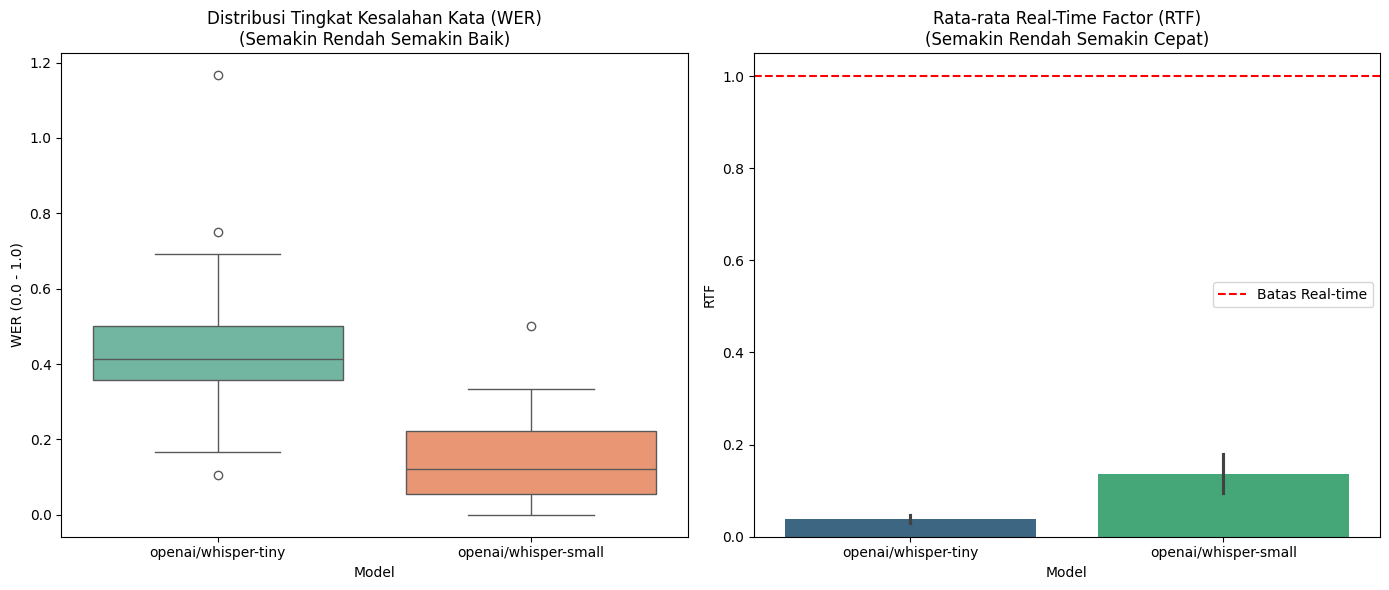


🔍 Analisis Kualitatif (Contoh Transkripsi):


,Model,Ref,Pred,WER
26,openai/whisper-tiny,serupa halnya dengan itu pria diharuskan memak...,serupa hanya teman itu periatih haruskan memak...,0.7500
6,openai/whisper-tiny,di kepulauan dan danau anda tidak perlu kapal ...,di kebuluhan dan danau anda tidak perlu kapal ...,0.2222
25,openai/whisper-tiny,peradaban adalah sebuah kebudayaan tunggal yan...,pergadaban adalah sebuah kebudayaan tunggal ya...,0.2778


In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

# @title Laporan Visualisasi Data

# 1. Tampilkan Tabel Statistik Rata-Rata
summary_df = df_results.groupby('Model')[['WER', 'RTF', 'Inference_Time_s']].mean().reset_index()
print("\n🏆 SUMMARY TABLE (Rata-rata):")
display(summary_df)

# 2. Setup Plot
plt.figure(figsize=(14, 6))

# Plot A: Distribusi Error (WER)
# Boxplot menunjukkan: Minimum, Quartile 1, Median, Quartile 3, Maximum
plt.subplot(1, 2, 1)
sns.boxplot(x='Model', y='WER', data=df_results, palette='Set2')
plt.title("Distribusi Tingkat Kesalahan Kata (WER)\n(Semakin Rendah Semakin Baik)")
plt.ylabel("WER (0.0 - 1.0)")

# Plot B: Distribusi Kecepatan (RTF)
plt.subplot(1, 2, 2)
sns.barplot(x='Model', y='RTF', data=df_results, palette='viridis', errorbar='sd')
plt.axhline(1.0, color='red', linestyle='--', label='Batas Real-time')
plt.title("Rata-rata Real-Time Factor (RTF)\n(Semakin Rendah Semakin Cepat)")
plt.legend()

plt.tight_layout()
plt.show()

# 3. Tampilkan Sampel Kualitatif (Text vs Text)
print("\n🔍 Analisis Kualitatif (Contoh Transkripsi):")
# Ambil 3 sampel acak dari data
sample_view = df_results.sample(3)[['Model', 'Ref', 'Pred', 'WER']]
display(sample_view)